In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import babet as bb
from moarpalettes import get_palette
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches
from cmcrameri import cm
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
color_palette = get_palette.Petroff6().to_sn_palette()
color_palette

[(0.3411764705882353, 0.5647058823529412, 0.9882352941176471),
 (0.9725490196078431, 0.611764705882353, 0.12549019607843137),
 (0.8941176470588236, 0.1450980392156863, 0.21176470588235294),
 (0.5882352941176471, 0.2901960784313726, 0.5450980392156862),
 (0.611764705882353, 0.611764705882353, 0.6313725490196078),
 (0.47843137254901963, 0.12941176470588237, 0.8666666666666667)]

In [3]:
# Plot settings
uk = [-10.5, 9.5, 45.5, 61.3] # longitude min, longitude max, latitude min, latitude max
northsea = [-17, 20, 40, 70]

# Load data

In [4]:
pgw = bb.data.Data.get_pgw()

Importing data from pre-existing file


In [19]:
# check if file exists
if not os.path.exists('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_clean_dynamics.nc'):
    # qvi
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_qvi_past.nc').expand_dims(climate=["1870"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_qvi_prst.nc').expand_dims(climate=["present"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_qvi_fut1.nc').expand_dims(climate=["future1"])
    tmp4 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_qvi_fut2.nc').expand_dims(climate=["future2"])
    tmp = xr.concat([tmp1, tmp2, tmp3, tmp4], dim="climate").rename({"unknown": "qvi"})

    ds = xr.Dataset(
        data_vars=dict(
            qvi=(["climate", "time", "lat", "lon"], tmp.qvi.values)),
        coords=dict(
            lon=tmp.lon.values[0,:],
            lat=tmp.lat.values[:,0],
            time=tmp.time.values,
            climate=tmp.climate.values),
        attrs=dict(description="PGW data"))

    # upward latent heat flux
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_latf_past.nc').expand_dims(climate=["1870"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_latf_prst.nc').expand_dims(climate=["present"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_latf_fut1.nc').expand_dims(climate=["future1"])
    tmp4 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_latf_fut2.nc').expand_dims(climate=["future2"])
    tmp = xr.concat([tmp1, tmp2, tmp3, tmp4], dim="climate").rename({"unknown": "latf"})
    pgw_dynamics = xr.merge([ds,
                    xr.Dataset(data_vars=dict(
                            latf=(["climate", "time", "lat", "lon"], tmp.latf.values)),
                            coords=dict(lon=tmp.lon.values[0,:],
                                    lat=tmp.lat.values[:,0],
                                    time=tmp.time.values,
                                    climate=tmp.climate.values),
                            attrs=dict(description="PGW data"))], 
                    compat="override")

    # Save to netcdf
    pgw_dynamics.to_netcdf('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_clean_dynamics.nc')
else:
    print('Importing data from pre-existing file')
    pgw_dynamics = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_clean.nc')

In [20]:
pgw_tempmean = pgw_dynamics.sel(time=slice('2023-10-19 00', '2023-10-22 00')).mean(dim='time').compute()

# Plot

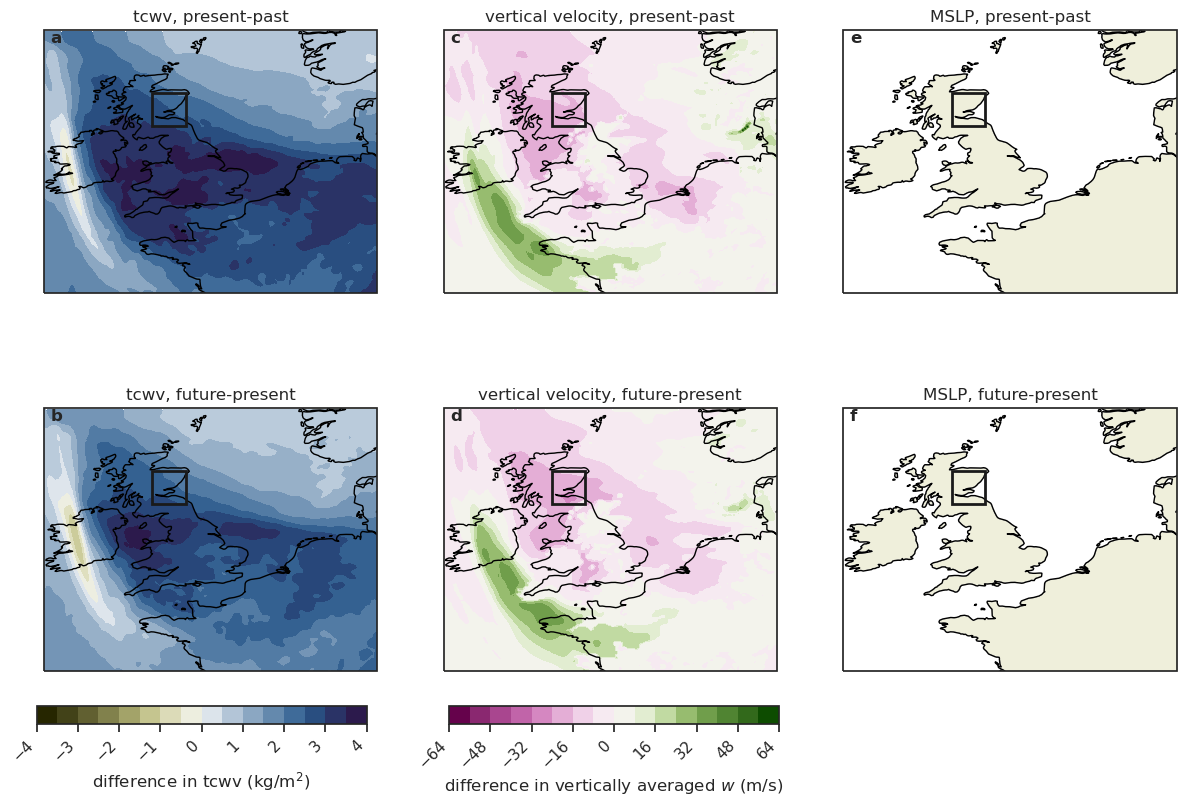

In [22]:
# Create figure
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot saturation specific humidity
plot1 = (pgw_tempmean.sel(climate='present')-pgw_tempmean.sel(climate='1870')).qvi.plot.contourf(
    cmap=cm.broc_r,# vmin=-7, vmax=7,
    levels=20, ax=axes[0, 0], add_colorbar=False  # Disable individual colorbars
)
plot2 = (pgw_tempmean.sel(climate='future1')-pgw_tempmean.sel(climate='present')).qvi.plot.contourf(
    cmap=cm.broc_r, #vmin=-7, vmax=7,
    levels=20, ax=axes[1, 0], add_colorbar=False  # Disable individual colorbars
)

# Plot vertical velocity
plot3 = (pgw_tempmean.sel(climate='present')-pgw_tempmean.sel(climate='1870')).latf.plot.contourf(
    cmap=cm.bam, #vmin=-0.1, vmax=0.1,
    levels=20, ax=axes[0,1], add_colorbar=False  # Disable individual colorbars
)
plot4 = (pgw_tempmean.sel(climate='future1')-pgw_tempmean.sel(climate='present')).latf.plot.contourf(
    cmap=cm.bam, #vmin=-0.1, vmax=0.1,
    levels=20, ax=axes[1,1], add_colorbar=False  # Disable individual colorbars
)

# Add horizontal colorbars
cbar_ax1 = fig.add_axes([0.12, 0.08, 0.22, 0.02])  # Bottom of first column
cbar1 = fig.colorbar(plot1, cax=cbar_ax1, orientation="horizontal", label="difference in tcwv (kg/m$^2$)")
cbar1.ax.xaxis.set_label_position('bottom')

cbar_ax2 = fig.add_axes([0.395, 0.08, 0.22, 0.02])  # Bottom of second column
cbar2 = fig.colorbar(plot3, cax=cbar_ax2, orientation="horizontal", label="difference in vertically averaged $w$ (m/s)")
cbar2.ax.xaxis.set_label_position('bottom')

for cbar in [cbar1, cbar2]:  
    for label in cbar.ax.get_xticklabels():  # For horizontal colorbars  
        label.set_rotation(45)  
        label.set_ha('right')  # Align labels to the right for better readability


# Add figure labels
axes[0, 0].text(0.02, 0.95, "a", transform=axes[0, 0].transAxes, fontsize=12, fontweight="bold")
axes[1, 0].text(0.02, 0.95, "b", transform=axes[1, 0].transAxes, fontsize=12, fontweight="bold")
axes[0, 1].text(0.02, 0.95, "c", transform=axes[0, 1].transAxes, fontsize=12, fontweight="bold")
axes[1, 1].text(0.02, 0.95, "d", transform=axes[1, 1].transAxes, fontsize=12, fontweight="bold")
axes[0, 2].text(0.02, 0.95, "e", transform=axes[0, 2].transAxes, fontsize=12, fontweight="bold")
axes[1, 2].text(0.02, 0.95, "f", transform=axes[1, 2].transAxes, fontsize=12, fontweight="bold")

# Apply Cartopy settings to both axes
titles = [f"tcwv, present-past", f"vertical velocity, present-past", f"MSLP, present-past",
         f"tcwv, future-present", f"vertical velocity, future-present",  f"MSLP, future-present"]
for ax, title in zip(axes.flatten(), titles):
    ax.set_extent(uk, crs=ccrs.PlateCarree())  # Set map extent
    ax.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.8)  # Add land borders
    ax.add_feature(cfeature.OCEAN, facecolor='white')  # Mask ocean
    ax.coastlines()  # Add coastlines
    ax.set_title(title, fontsize=12)  # Set

    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=ccrs.PlateCarree())
    ax.add_patch(rectangle)
    rectangle.set_zorder(17)
plt.subplots_adjust(right=0.88)